In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata = sc.read_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_not_scrubed_for_publication.h5ad")
adata

AnnData object with n_obs × n_vars = 125184 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
doublets = adata.obs['predicted_doublets']
print(f"Identified {doublets.sum()} doublets.")
# filter out doublets
adata_filtered = adata[~adata.obs['predicted_doublets'], :]
print('Total number of cells before filtering:', adata.n_obs)
print('Total number of cells after filtering:', adata_filtered.n_obs)

Identified 2563 doublets.
Total number of cells before filtering: 125184
Total number of cells after filtering: 122621


# 1. Re-run logT and normalization after doublet removal 

In [14]:
adata=adata_filtered
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var, uns=adata.uns)
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
#remove 16_week data from adata (these data were not used in any analyses)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 122621 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group',"CD3D",'CD8A',"SFTPB","AGER","DCN","CSF1R"],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=18, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
sc.pl.umap(adata, color = ["Group"])

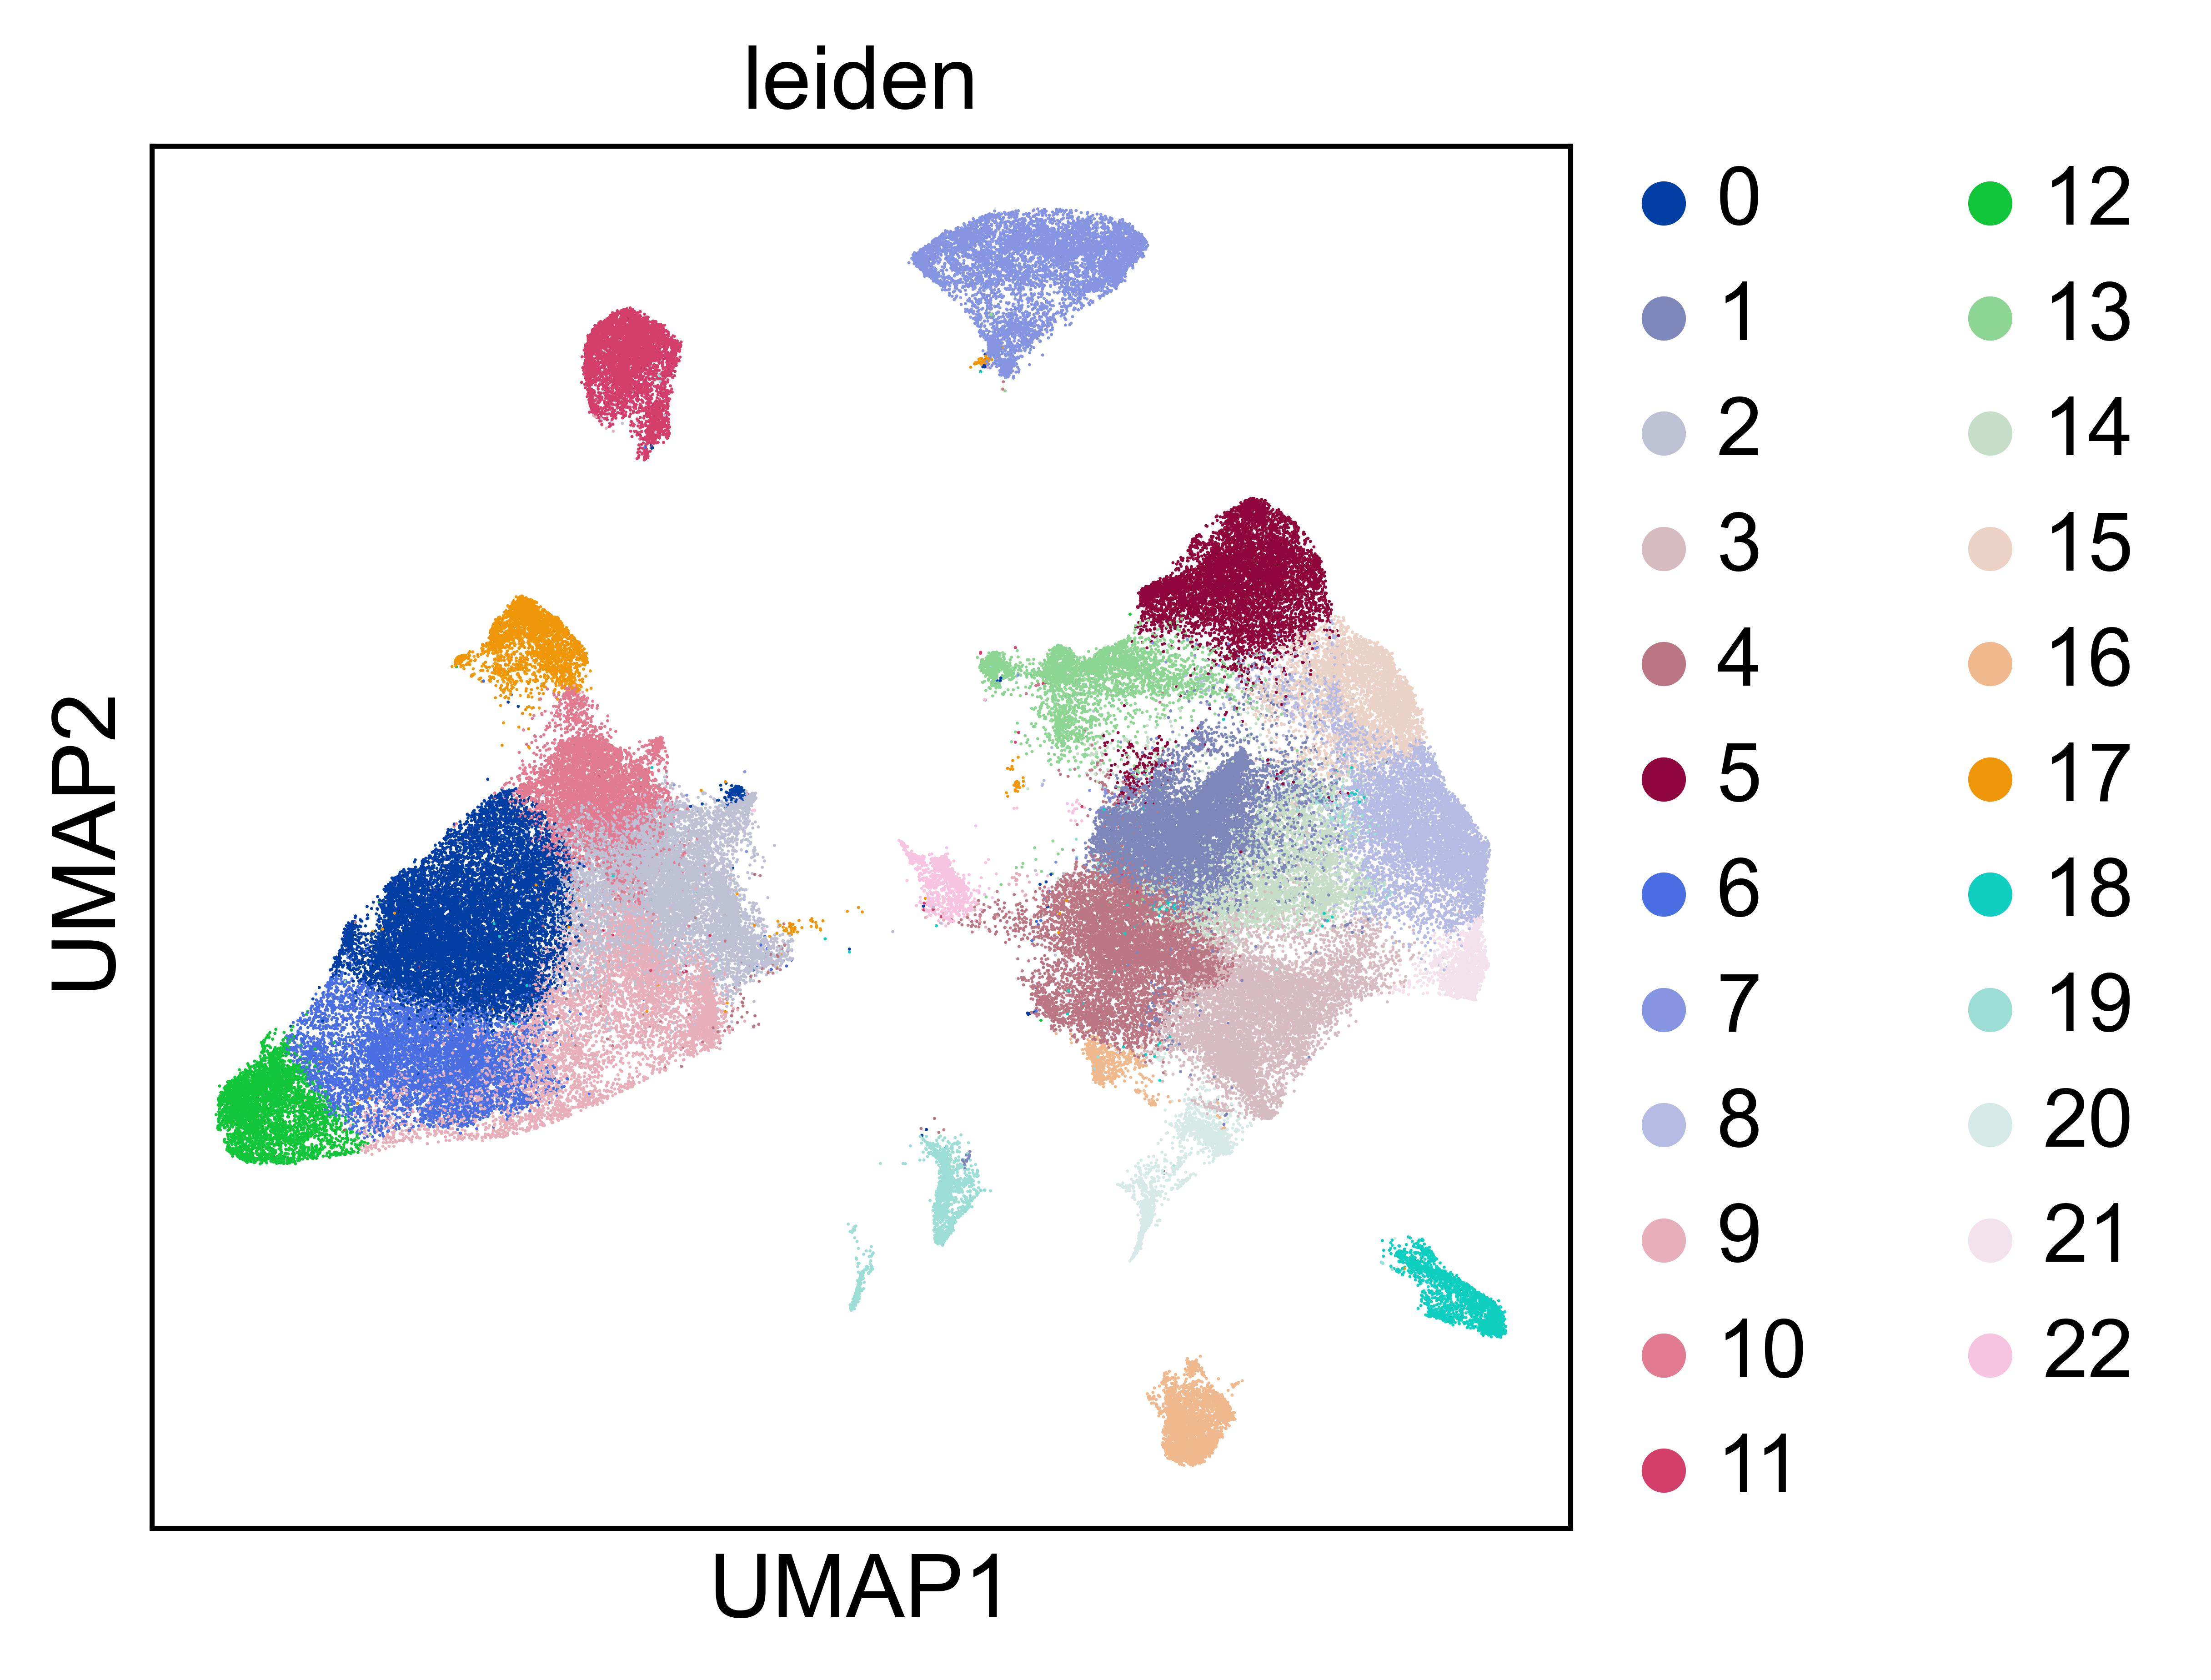

In [18]:
sc.tl.leiden(adata,resolution=1)
sc.pl.umap(adata, color = ["leiden"])

In [20]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))


0             1             2             3             4  \
0           GZMK         CXCL9        SPOCK2         FABP4           HBB   
1         FAM46C        JCHAIN  LOC101925857          APOE          CPA3   
2           ETS1        CXCL10          CD3D           LYZ  LOC102133296   
3           CD8A           LYZ        IFITM1          CPA3        JCHAIN   
4         PIK3R1          APOE           LTB         GPNMB           LYZ   
5          CXCR4  LOC102133296          CD28          CTSB          APOE   
6   LOC101925857          SOD2          ETS1        LGALS3      rna76576   
7        TNFAIP3          IDO1           CD6          C1QB  LOC102139613   
8   LOC102133263         PLAC8  LOC102133263         APOC1        FCER1A   
9           CD3D           HBB           LAT         FABP5  LOC102142071   
10          NKG7         CXCL8           CD5           FN1          HPGD   
11          PAG1  LOC102128706       ZFP36L2         CHIT1  LOC102142558   
12        STK17B        CXCL11        STK17A          MRC1  LOC107126411   
13  LOC102135442          CTSB        FAM46C         ALDH2  LOC102128706   
14        IFITM1          G0S2        GIMAP7           CPM         FABP4   
15         IL2RB           UBD          IL7R           FTL  LOC102144039   
16          CD27         GPNMB          RORA           CFD  LOC102141751   
17           LTB  LOC102144039  LOC102135442          GPX1  LOC102141414   
18       ZFP36L2      ADAMDEC1          DGKA  LOC102144039         CXCL9   
19          CCL5         SFTPC        ABLIM1  LOC102139613           CLU   

               5             6             7             8             9  \
0           PSAP          GZMH         CSF3R          APOE  LOC101925857   
1            CFD          CCL5          SOD2         GPNMB  LOC102133263   
2           MNDA          GZMB          PLEK          CTSB          ETS1   
3          CSF1R          NKG7  LOC102146914          LGMN          CD3D   
4        EMILIN2          ETS1  LOC102147203          CD68  LOC102135442   
5   LOC102126493          GNLY         CXCL8          CTSC           CD6   
6          MPEG1        PIK3R1        BCL2A1           GRN          CD3G   
7          TGFBI          CST7        NFKBIA          LIPA  LOC102137723   
8            CFP         SYNE1         LIMK2          PSAP           LAT   
9           FGL2          CD8A        ZCCHC6        DNASE2           CD5   
10          AIF1  LOC102135442         IFIT3          CTSZ         SCML4   
11         TIMP1  LOC102128672          IRF1           FTL          CD8A   
12          IL1B        FAM65B    C7H15orf48         CREG1        GIMAP7   
13          FCN1        TGFBR3        FCGR2B  LOC102144039          CD27   
14        CDKN1A  LOC102133263         TXNIP          CD63          RORA   
15  LOC102122418        FAM46C  LOC102118223         IFI30        FAM46C   
16         IFI30          PRF1         CD274         LAMP1        SPOCK2   
17         C5AR1         PRKCH        CSF2RB          NPC2         PRKCH   
18          VCAN         SYTL2        FCGR2A          GPX1        IFITM1   
19           LYN          CD3G          G0S2          CTSA          TNIK   

              10            11            12            13            14  \
0            LTB         MS4A1          GNLY          CD74          APOE   
1         SPOCK2         BANK1          GZMH  LOC102136468          C1QB   
2   LOC101925857          CD19          CCL5  LOC102136862          C1QA   
3           CD3D         CD79B          GZMB         SULF2         GPNMB   
4            LAT          FCMR  LOC102115168  LOC102144039      ADAMDEC1   
5          FURIN         MEF2C         CD247         PLAC8          CTSB   
6            CD2         CXCR5          PRF1         PEA15          CD68   
7       TNFRSF25  LOC102116308          NKG7  LOC102141176          C1QC   
8          PRKCH          CD74           TXK  LOC102140649           FTL   
9   LOC102133263         SMAP2  LOC102132533  LOC102144414   

In [23]:
cell_indentities_original={"0":"TNK cells",
                           "1":"Macrophages",
                           "2":"TNK cells",
                           "3":"Macrophages",
                           "4":"Macrophages",
                           "5":"Macrophages",
                           "6":"TNK cells",
                           "7":"Neutrophils",
                           "8":"Macrophages",
                           "9":"TNK cells",
                           "10":"TNK cells",
                           "11":"B cells",
                           "12":"TNK cells",
                           "13":"Macrophages",
                           "14":"Macrophages",
                           "15":"Macrophages",
                           "16":"Mast cells",
                           "17":"TNK cells",
                           "18":"Endothelial cells",
                           "19":"Nonimmune cells",
                           "20":"Fibroblasts",
                           "21":"Macrophages",
                           "22":"Plasma cells"}

adata.obs['leiden_lab_orig'] = adata.obs['leiden'].map(cell_indentities_original)

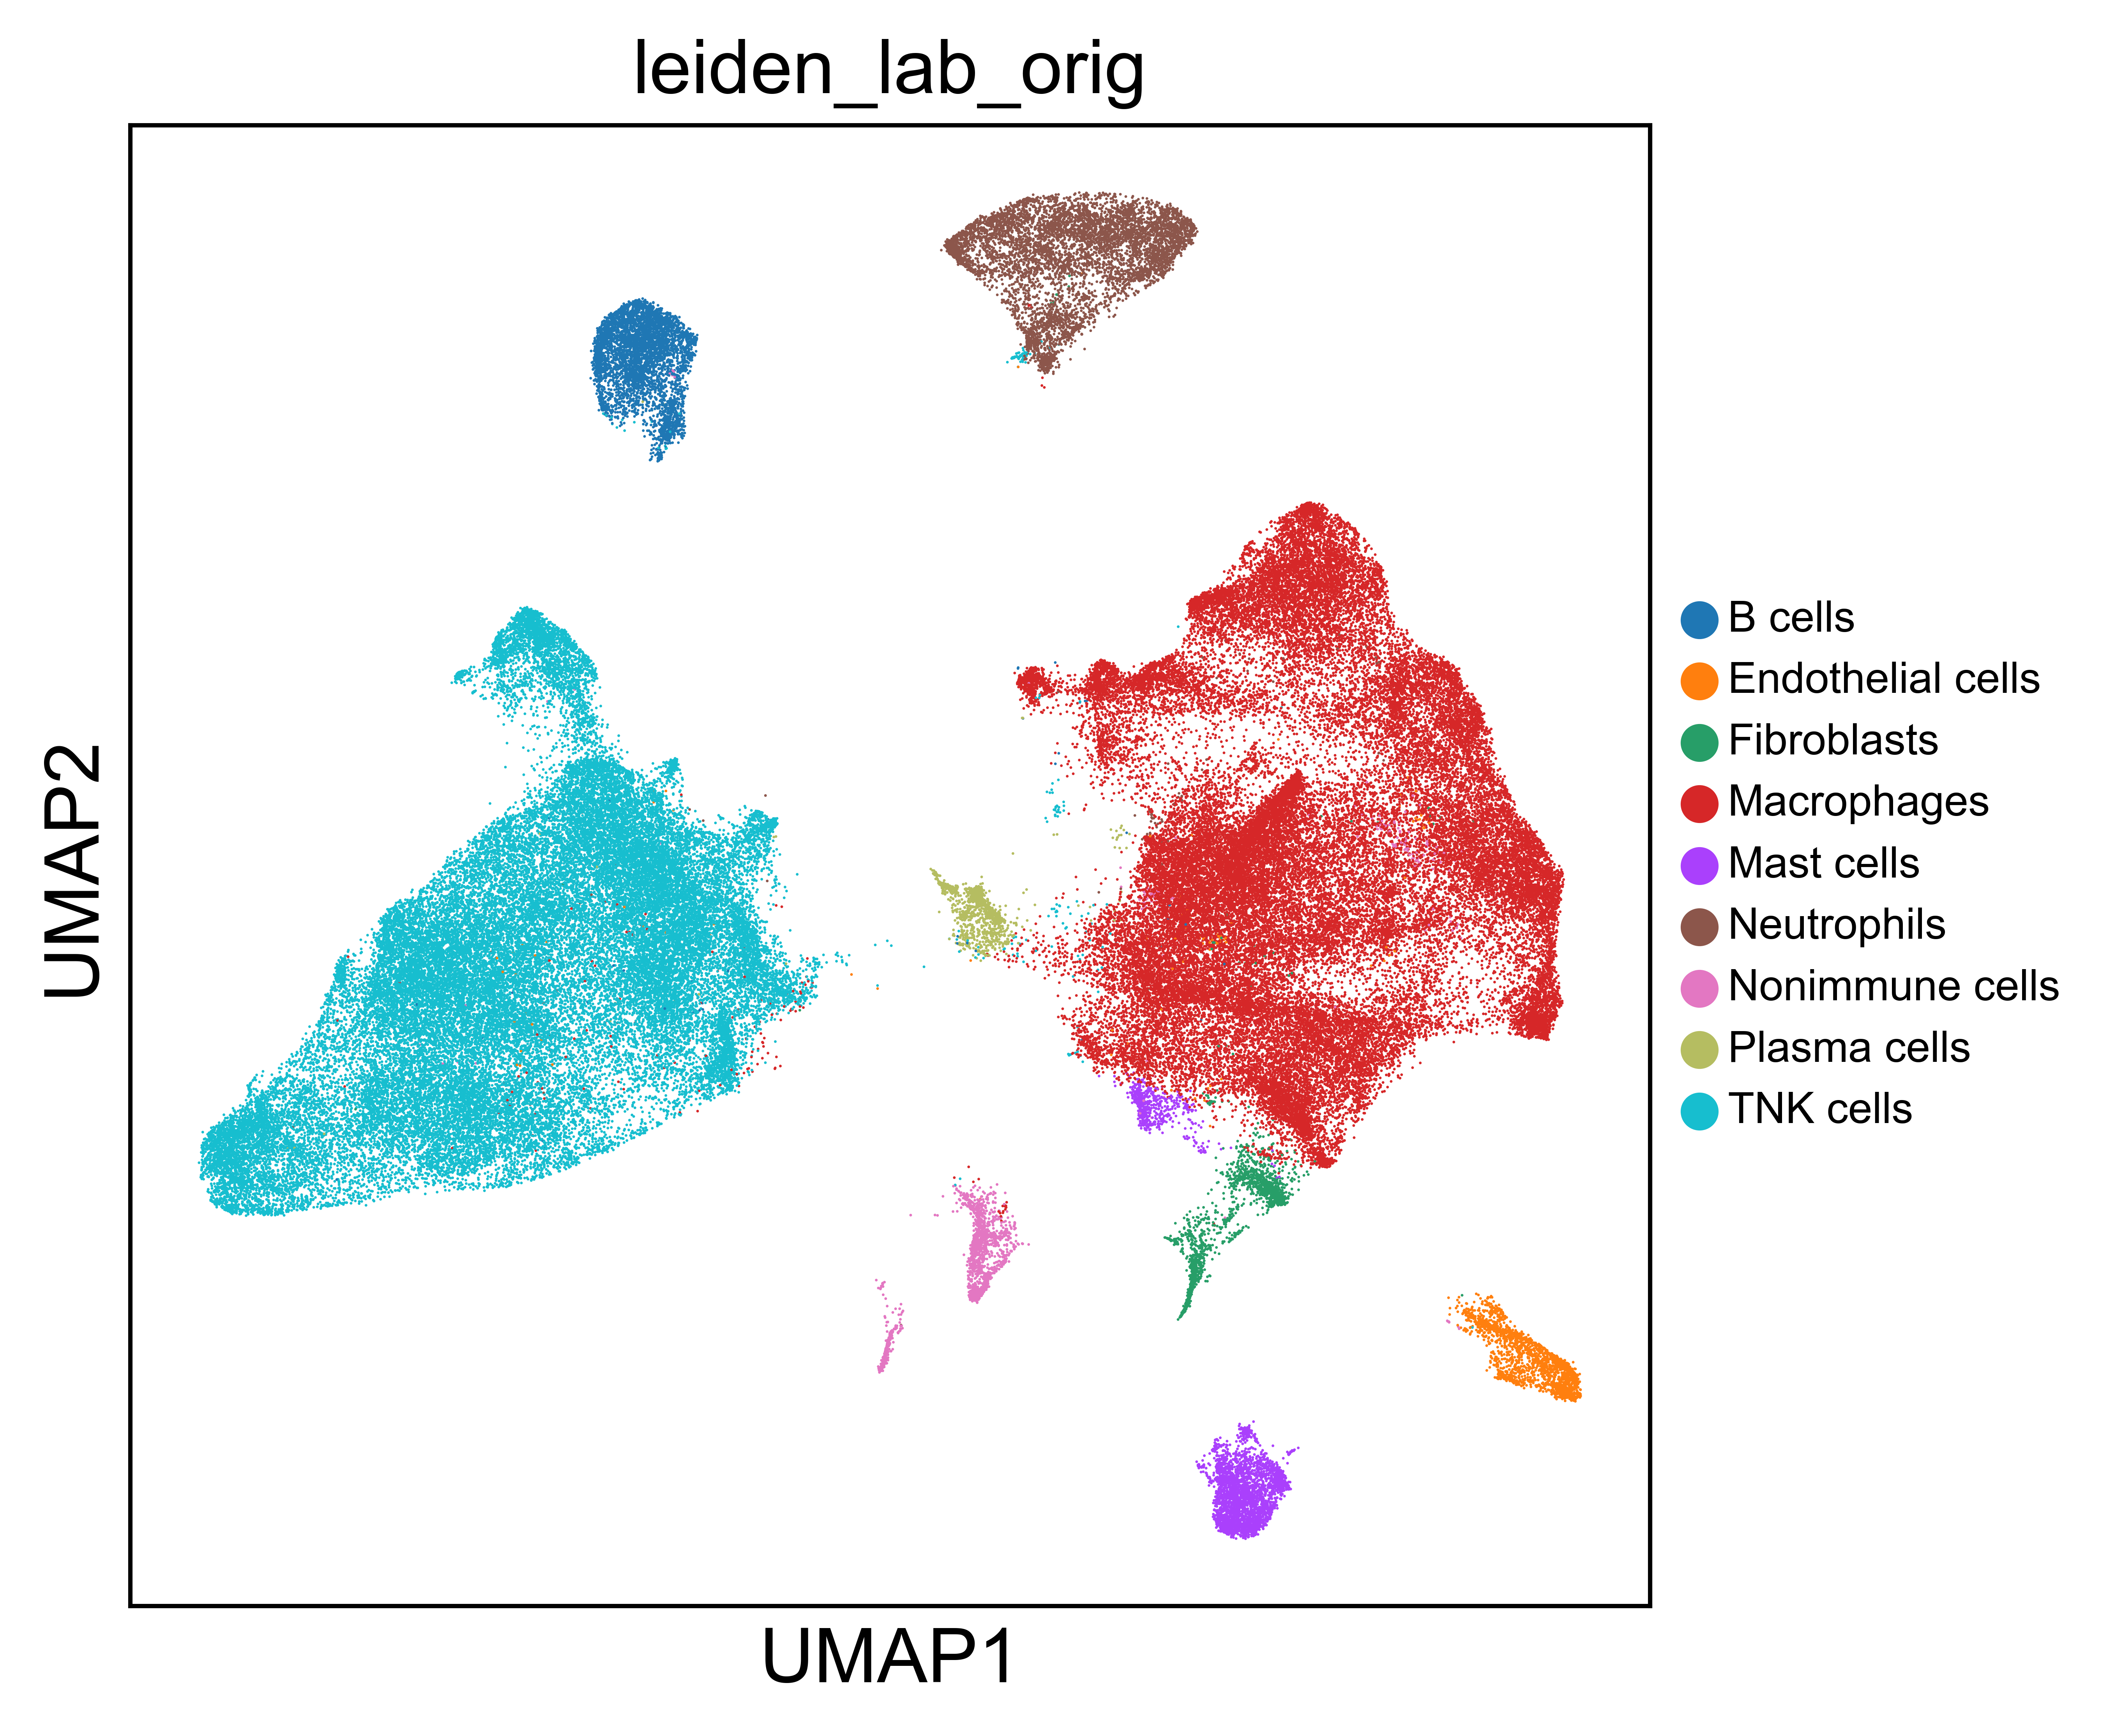

In [24]:
sc.pl.umap(adata, color=['leiden_lab_orig'], legend_fontsize=8,use_raw=False)

In [26]:
adata.write_h5ad("./Scanpy_H5AD/adata_CellBender_Scrublet_Srubed_for_publication.h5ad")